100%|███████████████████████████████████████████| 14/14 [00:00<00:00, 23.13it/s]


NumImg: 14
Rep Error: 0.47630105259252936
Camera Matrix: [[1.51634919e+03 0.00000000e+00 7.15673857e+02]
 [0.00000000e+00 1.51901413e+03 9.68117419e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
disCoeffs:  [[ 1.17319849e+01  1.37450951e+01 -2.27996809e-04 -1.18358080e-03
  -9.22997809e+01  1.13161285e+01  1.41907175e+01 -9.11921287e+01
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]
ret:  0.47630105259252936


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  7.21it/s]


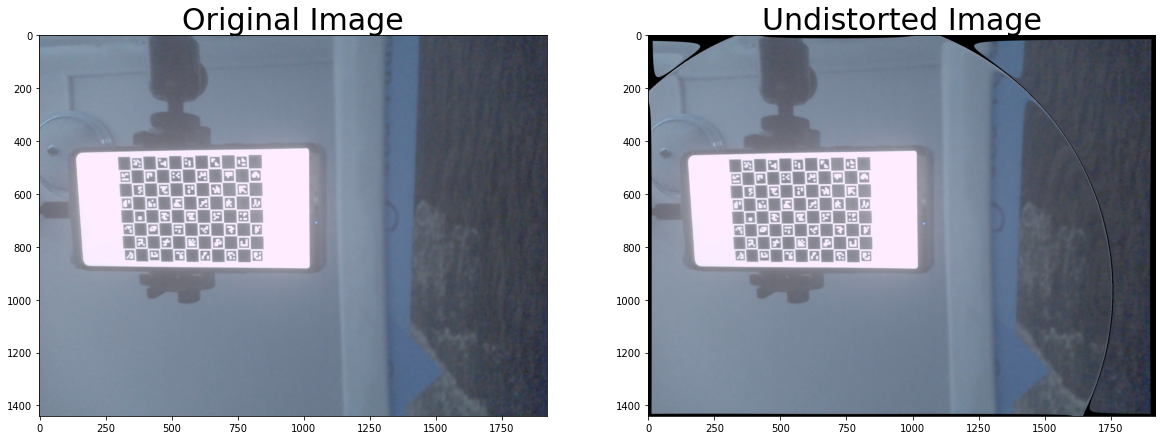

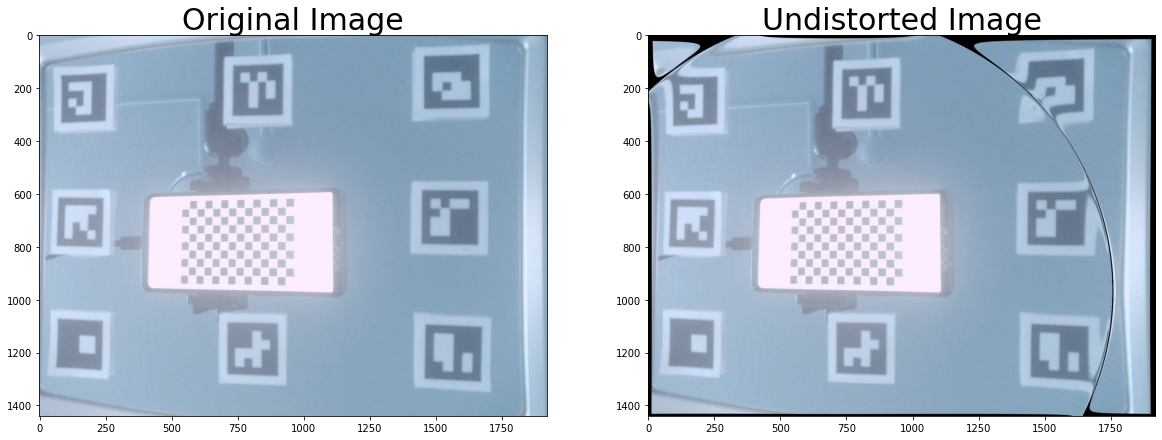

In [1]:
import sys
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from cv2 import aruco
from skimage import color
from tqdm import tqdm

class IntrinsicCalibration:
    def __init__(self, dict_aruco=cv2.aruco.DICT_4X4_250, sqWidth=11, sqHeight=8, checkerSquareSize=0.023,
                 markerSquareSize=0.017, criteria_eps=1e-9, criteria_count=10000):
        # Initialize ChArUco Board size values: default DINA4
        # Visit: https://calib.io/pages/camera-calibration-pattern-generator
        # To create: calib.io_charuco_279x215_8x11_24_DICT_4X4.pdf
        # Initialize dictionary, see more in OpenCV
        self.dict = dict_aruco
        
        self.sqWidth = sqWidth # Amount of squares in width
        self.sqHeight = sqHeight # Amount of squares in heights
        self.checkerSquareSize = checkerSquareSize # Size of checker square on printed ChArUco board in meter
        self.markerSquareSize = markerSquareSize # Size of marker square on printed ChArUco board in meter
        self.criteria_eps = criteria_eps
        self.criteria_count = criteria_count

        # results from intrinsic calibration
        self.cameraMatrix = None
        self.distortionCoeff = None
        self.ret = None
        self.rvecs = None
        self.tvecs = None

    def readFileList(self, imgFolder, imgPattern):
        # Read all PNG files in folder
        imgFileList = glob.glob(os.path.join(imgFolder, imgPattern))
        imgFileList.sort()
        return imgFileList

    def calibration(self, imgFolder, imgPattern):
        if not os.path.exists(imgFolder): 
            os.mkdir(imgFolder)

        imgFileList = self.readFileList(imgFolder, imgPattern) # Retrieve Images
        allCorners = [] # All Charuco Corners
        allIds = [] # All Charuco Ids
        dictionary = aruco.getPredefinedDictionary(self.dict) # Retrieve dictionary
        board = cv2.aruco.CharucoBoard((self.sqWidth, self.sqHeight), self.checkerSquareSize,
                                              self.markerSquareSize, dictionary)
        # Loop through images
        if not os.path.exists(os.path.join(imgFolder, 'detect')):
            os.mkdir(os.path.join(imgFolder, 'detect'))

        for i in tqdm(imgFileList):
            # Load image to grayscale
            if i.endswith('.JPG') or i.endswith('.jpg') or i.endswith('.tif'):
                img = cv2.imread(i)
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                gray = cv2.flip(gray, 1)
            elif imgPattern == "*.npy":
                img = np.load(i)
                if len(img.shape) > 2:
                    gray = color.rgb2gray(img)
                else:
                    gray = img
            else:
                # print("Specify image pattern: PNG and npy are supported")
                continue
            
            [markerCorners, markerIds, rejectedImgPoints] = cv2.aruco.detectMarkers(gray, dictionary) # Detect markers
            
            if len(markerCorners) > 0: # Draw markers
                [ret, charucoCorners, charucoIds] = cv2.aruco.interpolateCornersCharuco(markerCorners, markerIds, gray, board)
                if charucoCorners is not None and charucoIds is not None and len(charucoCorners) > 3:
                    allCorners.append(charucoCorners)
                    allIds.append(charucoIds)

                cv2.aruco.drawDetectedMarkers(img, markerCorners, markerIds, [0, 255, 0])
                cv2.aruco.drawDetectedCornersCharuco(img, charucoCorners, charucoIds, [0, 0, 255])

            #cv2.namedWindow('Frame', cv2.WINDOW_NORMAL)
            #cv2.imshow('Frame', img)
            #cv2.waitKey(0)  # any key
            
            imgSaveTiff = os.path.join(imgFolder, 'detect', os.path.basename(i))
            cv2.imwrite(imgSaveTiff, img)
            
        print("NumImg:", len(allCorners))
        
        try:
            # Calibrate camera
            [ret, cameraMatrix, disCoeffs, rvecs, tvecs, _, _,
             perViewErrors] = cv2.aruco.calibrateCameraCharucoExtended(
                allCorners, allIds, board, (img.shape[0], img.shape[1]),
                None, None, flags=cv2.CALIB_RATIONAL_MODEL,
                criteria=(cv2.TERM_CRITERIA_EPS & cv2.TERM_CRITERIA_COUNT, self.criteria_count, self.criteria_eps))
            
            # Print computed calibration results
            print("Rep Error:", ret)
            print("Camera Matrix:", cameraMatrix)
            print("disCoeffs: ", disCoeffs)
            print("ret: ", ret)
            # print("Per View Errors:", perViewErrors)

            # Save calibration results in dedicated folder for numpy data of calibration
            # np.savez('intrinsic_calibration.npz', ret=ret, mtx=cameraMatrix, dist=disCoeffs, rvecs=rvecs, tvecs=tvecs)
            
            # Set class attributes
            self.cameraMatrix = cameraMatrix
            self.distortionCoeff = disCoeffs
            self.ret = ret
            self.rvecs = rvecs
            self.tvecs = tvecs
        except ValueError as e:
            print(e)
        except NameError as e:
            print(e)
        except AttributeError as e:
            print(e)
        except:
            print("calibrateCameraCharuco fail:", sys.exc_info()[0])

    def undistort(self, imgFolder, imgPattern):
        # Load calibration, if necessary
        # if self.cameraMatrix is None:
        #     self.load_calibration_data()

        # Undistort the images
        imgDistortFolder = self.readFileList(imgFolder, imgPattern) # Retrieve Images
        # Loop through images to undistort
        for j in tqdm(imgDistortFolder):
            # Load specified image file pattern
            if j.endswith('.JPG') or j.endswith('.jpg') or j.endswith('.tif'):
                imgDistort = cv2.imread(j)
            elif imgPattern == "*.npy":
                imgDistort = np.load(j)
            else:
                continue
            h = imgDistort.shape[0]
            w = imgDistort.shape[1]
            
            # Undistort
            dst = cv2.undistort(imgDistort, self.cameraMatrix, self.distortionCoeff, None)
            if not os.path.exists(os.path.join(imgFolder, 'undistort')):
                os.mkdir(os.path.join(imgFolder, 'undistort'))
            # Save image in specified image pattern in destination folder - by default captured image/npy
            
            if imgPattern == '*.JPG' or imgPattern == '*.jpg' or imgPattern == '*.tif':
                imgSave = os.path.join(imgFolder, 'undistort', os.path.basename(j))
                # gray = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
                cv2.imwrite(imgSave, dst)
                f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
                ax1.imshow(imgDistort)
                ax1.set_title('Original Image', fontsize=30)
                ax2.imshow(dst)
                ax2.set_title('Undistorted Image', fontsize=30)
            elif imgPattern == "*.npy":
                imgSaveNpy = os.path.join(imgFolder, os.path.basename(j))
                np.save(imgSaveNpy, dst)
                imgSavePng = os.path.join(imgFolder, os.path.basename(j))
                cv2.imwrite(imgSavePng, dst)
            else:
                print("Specify image pattern: .tiff and .PNG and .npy are supported")
                # continue

if __name__ == '__main__':
    intrinsic_calib = IntrinsicCalibration(dict_aruco=cv2.aruco.DICT_4X4_250, sqWidth=10, sqHeight=7, checkerSquareSize=0.025, markerSquareSize=0.01926)
    
    intrinsic_calib.calibration(imgFolder="./data/capture_intrinsic/", imgPattern="*.jpg") # intrinsic calibration
    intrinsic_calib.undistort(imgFolder="./data/capture_geometric/", imgPattern="*.jpg") # undistort other imgs from different folder based on intrinsic calibration result